# Lab 9 Dense Tasks: Segmentation + Object Detection

## Part 1: Semantic Segmentation

This first part is on image segmentation, in particular semantic segmentation where we want to classify each pixel in the image as a set of predefined classes. Other types of segmentation are instance segmentation where we want to distinguish different individual targets, and panoptic segmentation where we want to do both.

You may want to copy this notebook to Google Colab to use GPU for training. You should then select the GPU/TPU run-time within Google Colab.

To measure the quality of our outputs, we need special metrics and therefore will use `torchmetrics`.

In [ ]:
!pip install torchmetrics torchmetrics[detection] ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 121.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
import torch
from torchvision.transforms import v2 as transforms
from torch.nn import functional as F
import torchvision
import torchmetrics
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os, random, re

### Data Preparation

Let's start by downloading the data. We will be using the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2025-05-11 14:34:56--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-05-11 14:34:57--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  31.2MB/s    in 25s     

2025-05-11 14:35:22 (29.9 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2025-05-11 14:35:22--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.o

The data was downloaded into the notebook. You can see it in Files (to the left of the notebook) in Google Colab. The images are in the folder ```images``` and the masks in ```annotations/trimaps```.

In the annotations you will notice a file named ```trainval.txt``` which contains the names of images typically used for training and validation, and ```test.txt``` which contains the images typically used for testing. Let's separate the data into training, validation and testing based on these files.

## Define Dataset

In [ ]:
class OxfordPetDataset:
    def __init__(self, root, fold, transform=None):
        assert fold in ['train', 'val', 'test']
        self.root = root
        fname = 'trainval.txt' if fold in ('train', 'val') else 'test.txt'
        self.files = [
            # get the filenames
            line.split()[0] for line in open(os.path.join(root, 'annotations', fname)).readlines()
            # use only cats to keep the dataset smaller and faster to train
            if line.split()[2] == '1'
        ]
        # filter images without labels
        self.files = [f for f in self.files if os.path.exists(os.path.join(root, 'annotations', 'xmls', f + '.xml'))]
        if fold in ['train', 'val']:
            random.seed(42)
            random.shuffle(self.files)
            i = int(0.8*len(self.files))
            self.files = self.files[:i] if fold == 'train' else self.files[i:]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        image = torchvision.tv_tensors.Image(torchvision.io.decode_image(os.path.join(self.root, 'images', fname + '.jpg')))
        # the mask has 3 labels [pet (1), background (2), and border (3)], we merge pet and border.
        mask = torchvision.io.decode_image(os.path.join(self.root, 'annotations', 'trimaps', fname + '.png'), 'GRAY')
        mask = (mask == 1) | (mask == 3)
        mask = torchvision.tv_tensors.Mask(mask)
        xml = open(os.path.join(self.root, 'annotations', 'xmls', fname + '.xml')).read()
        bboxes = [{key: int(value) for key, value in re.findall(r'<(\w+)>(\d+)</\1>', bbox)}
            for bbox in re.findall(r'<bndbox>(.*?)</bndbox>', xml)]
        bboxes = [(bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']) for bbox in bboxes]
        bboxes = torchvision.tv_tensors.BoundingBoxes(bboxes, format='XYXY', canvas_size=image.shape[1:])
        if self.transform:
            image, mask, bboxes = self.transform(image, mask, bboxes)
        return image, mask, bboxes

In [ ]:
train_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomAffine(30, (0.2, 0.2), (0.8, 1.2))], 0.5),
    transforms.ToDtype(torch.float32, True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = OxfordPetDataset('.', 'train', train_transform)

Visualize examples from the data:

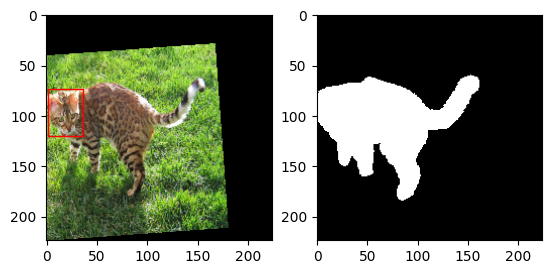

In [ ]:
image, mask, bboxes = train_dataset[0]
plt.subplot(1, 2, 1)
for x1, y1, x2, y2 in bboxes:
    plt.gca().add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='r'))
# we previously normalized images (x-μ)/σ and so we need to un-normalize them x*σ+μ for display
image = image.permute(1, 2, 0)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask[0], cmap='gray')
plt.show()

Define transformations to be applied to the images and data loaders

In [ ]:
# Define transformations to be applied to validation data
val_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Define dataloader for validation data
val_dataset = OxfordPetDataset('.', 'val', val_transform)

In [ ]:
# hyperparameters
batch_size = 8
num_workers = 4

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=lambda x: x, num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, collate_fn=lambda x: x, num_workers=num_workers)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(




```
# This is formatted as code
```

### Segmentation Model

```
┌────────┐                            ┌────────┐
│        │  ┌────┐            ┌────┐  │        │
│        │  │    │  ┌─┐  ┌─┐  │    │  │        │
│        │  │    │  └─┘  └─┘  │    │  │        │
│        │  └────┘            └────┘  │        │
└────────┘                            └────────┘
|______________________||______________________|
         Encoder              Decoder
        (resnet18)            (ours)
```

We are going to use `resnet18` as the encoder (so training is faster), and we will then build a decoder.

To build the decoder: you must build 5 blocks, each one composed of: a convolution, upsample (2x) and relu. Each one of the five block should have a convolution with sizes 512/256/128/64/32, respectively.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models


class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.LazyConv2d(out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        return self.block(x)

class MySegNet(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        # truncate'd resnet18 (without the classifier head)
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.encoder = nn.Sequential(*modules)

        # freeze encoder to make training faster
        for param in self.encoder.parameters():
            param.requires_grad = False
        # five blocks of convolution+upsample+relu with filter sizes 512/256/128/64/32
        # use lazy convolutions
        self.decoder = nn.Sequential(
            DecoderBlock(512),
            DecoderBlock(256),
            DecoderBlock(128),
            DecoderBlock(64),
            DecoderBlock(32)
        )

        self.out = nn.LazyConv2d(out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.out(x)
        return x

If you network is correct, the following code should output:

```torch.Size([8, 10, 224, 224])```

In [ ]:
model = MySegNet(10)
out = model(torch.zeros(8, 3, 224, 224))
print(out.shape)

torch.Size([8, 10, 224, 224])


### U-Net:

To avoid upsample artifacts, U-Net introduces skip-connections between the decoder and the respective activation map from the encoder.

```
            ┌──────────────────────────────────────────┐             
            │                                          │             
┌─────────┐ │           ┌──────────────────┐           │  ┌─────────┐
│         │ │  ┌──────┐ │                  │  ┌──────┐ │  │         │
│         │ │  │      │ │  ┌───┐     ┌───┐ ▼  │      │ ▼  │         │
│         ├─┴─►│      ├─┴─►│   ├────►│   ├─⊕─►│      ├─⊕─►│         ├
│         │    │      │    └───┘     └───┘    │      │    │         │
│         │    └──────┘                       └──────┘    │         │
└─────────┘                                               └─────────┘
|________________________________||_________________________________|
               Encoder                         Decoder
              (backbone)
```

Let's change your previous model, but now add concatenations between your decoder activations and the respective encoder layers from resnet-18.

In [ ]:
class MyUNet(MySegNet):
    def forward(self, x):
        # Collect encoder feature maps where spatial size changes
        encoder_features = []
        current = x
        for layer in self.encoder:
            prev_shape = current.shape
            current = layer(current)
            if current.shape[2:] != prev_shape[2:]:
                encoder_features.append(current)

        # Reverse for decoder use (deepest first)
        encoder_features = encoder_features[::-1]

        # Pass through decoder, concatenating with encoder features
        x = current  # this is the encoder's final output

        decoder_outputs = []
        for idx, decoder_block in enumerate(self.decoder):
            x = decoder_block(x)
            if idx < len(encoder_features):
                enc_feat = encoder_features[idx]
                # Upsample encoder feature to match decoder size if needed
                if enc_feat.shape[2:] != x.shape[2:]:
                    enc_feat = nn.functional.interpolate(enc_feat, size=x.shape[2:], mode='bilinear', align_corners=False)
                x = torch.cat([x, enc_feat], dim=1)  # Concatenate along channels
            decoder_outputs.append(x)

        x = self.out(x)
        return x


If you network is correct, the following code should output:

```torch.Size([8, 10, 224, 224])```

In [ ]:
model = MyUNet(10)
out = model(torch.zeros(8, 3, 224, 224))
print(out.shape)

torch.Size([8, 10, 224, 224])


For a more complex U-Net implementation, consider using [https://github.com/milesial/Pytorch-UNet](https://github.com/milesial/Pytorch-UNet).

### Train the model

Start by defining the model, the optimizer, loss and metric to evaluate the model.

In this case, we will use the Jaccard Index (also known as intersection over union) as the metric. Since pytorch does not have this metric implemented, we will use the ```torchmetrics``` package. [Click here](https://lightning.ai/docs/torchmetrics/stable/) to find out more about the metrics available on torchmetrics.

In [ ]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device:', device)

using device: cpu


In [ ]:
!pip install torchmetrics

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassJaccardIndex

# Use one of the models that you have built. You may compare both.
out_channels = 10

model = MySegNet(out_channels)
model.to(device)

# Define optimizer (e.g., AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
epochs = 5

# Define loss (e.g., binary cross entropy)
loss_fn = nn.CrossEntropyLoss()  # Use this for binary segmentation with raw logits

# Define metric from torchmetrics (e.g. Jaccard Index, Dice Coefficient, Pixel Accuracy)
metric = MulticlassJaccardIndex(num_classes=out_channels, average='macro')
metric.to(device)

MulticlassJaccardIndex()

One training/validation epoch:

In [ ]:
def one_epoch(model, optimizer, dataloader, is_training):
    model.train() if is_training else model.eval()
    avg_loss = avg_metric = 0.0
    metric.reset()

    for batch in dataloader:
        images = torch.stack([b[0] for b in batch]).to(device)
        masks = torch.stack([b[1] for b in batch]).squeeze(1).long().to(device)

        with torch.set_grad_enabled(is_training):
            preds = model(images)  # [B, C, H, W]

            loss = loss_fn(preds, masks)  # CrossEntropyLoss expects logits and [B, H, W]

            if is_training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        pred_classes = preds.argmax(dim=1)  # [B, H, W]

        metric.update(pred_classes, masks)

        avg_loss += loss.item() / len(dataloader)

    avg_metric = metric.compute().item()
    return avg_loss, avg_metric


Now implement the training cycle:

In [ ]:
train_history = {'loss': [], 'metric': []}
val_history = {'loss': [], 'metric': []}

for epoch in range(epochs):
  # compute train
  avg_loss, avg_metric = one_epoch(model, optimizer, train_dataloader, True)
  train_history['loss'].append(avg_loss)
  train_history['metric'].append(avg_metric)
  print(f'Epoch {epoch+1:2d}/{epochs} - Train loss: {avg_loss} - Train metric: {avg_metric}')

  # compute validation statistics
  avg_loss, avg_metric = one_epoch(model, optimizer, val_dataloader, False)
  val_history['loss'].append(avg_loss)
  val_history['metric'].append(avg_metric)
  print(f'Epoch {epoch+1:2d}/{epochs} - Val   loss: {avg_loss} - Val   metric: {avg_metric}')

Epoch  1/5 - Train loss: 0.7262011506294801 - Train metric: 0.2049255669116974
Epoch  1/5 - Val   loss: 0.40981076260407767 - Val   metric: 0.6897499561309814
Epoch  2/5 - Train loss: 0.3833899667202416 - Train metric: 0.7098339796066284
Epoch  2/5 - Val   loss: 0.35308422148227686 - Val   metric: 0.7240267992019653
Epoch  3/5 - Train loss: 0.34445315561557227 - Train metric: 0.7348467707633972
Epoch  3/5 - Val   loss: 0.36915857692559556 - Val   metric: 0.7109318971633911
Epoch  4/5 - Train loss: 0.32577388834650245 - Train metric: 0.7489889860153198
Epoch  4/5 - Val   loss: 0.34031255940596267 - Val   metric: 0.7344707250595093
Epoch  5/5 - Train loss: 0.3364131816868054 - Train metric: 0.7423228025436401
Epoch  5/5 - Val   loss: 0.3451522886753083 - Val   metric: 0.7310406565666199


Plot metrics and loss on training and validation sets obtained during the training process

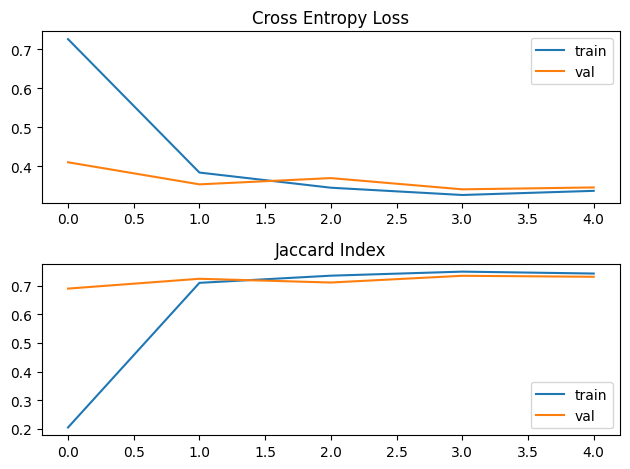

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Cross Entropy Loss')
plt.plot(train_history['loss'], label='train')
plt.plot(val_history['loss'], label='val')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.title('Jaccard Index')
plt.plot(train_history['metric'], label='train')
plt.plot(val_history['metric'], label='val')

plt.tight_layout()
plt.legend(loc='best')
plt.show()

### Visual inspection

Visualize the results on only a few images.

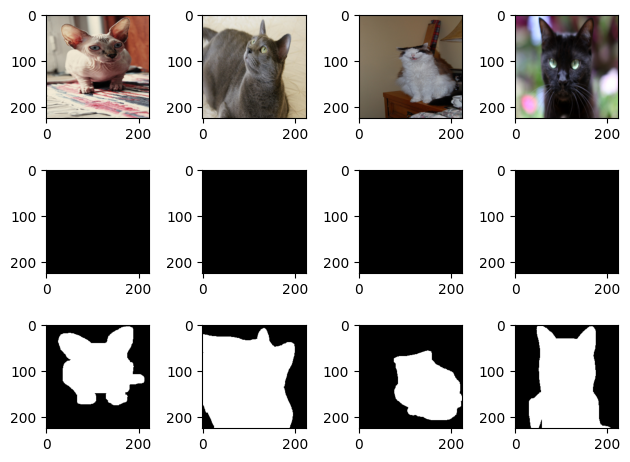

In [ ]:
model.eval()

batch = next(iter(val_dataloader))
images = torch.stack([b[0] for b in batch]).to(device)
masks = torch.stack([b[1] for b in batch]).to(device)
with torch.no_grad():
    preds = torch.sigmoid(model(images)) >= 0.5

for i in range(4):
    plt.subplot(3, 4, i+1)
    image = images[i].permute(1, 2, 0).cpu() * torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    plt.imshow(image)

    plt.subplot(3, 4, i+5)
    plt.imshow(preds[i, 0].cpu(), cmap='gray')

    plt.subplot(3, 4, i+9)
    plt.imshow(masks[i, 0].cpu(), cmap='gray')


plt.tight_layout()
plt.show()

## 2. Object Detection

Three families of deep object detectors exist (by chronological order): (1) two-stage (region-based), (2) one-stage (YOLO), (3) set-based (DETR).

We will focus on YOLO. This object detectors take advantage predict if each cell in the latent space corresponds to an object and, if so, what class and bounding box. Notice that the latent space is an activation map smaller than the image, therefore, each cell in that activation map corresponds to a region in the original image.

```
                                                  ┌────────────┐
┌─────────┐                                  ┌───►│P(object)   │
│         │    ┌──────┐                      │    │aka Score   │
│         │    │      │    ┌───┐     ┌───┐   │    └────────────┘
│         ├───►│      ├───►│   ├────►│   ├───┤    ┌────────────┐
│         │    │      │    └───┘     └───┘   │    │Bounding box│
│         │    └──────┘                      └───►│xc,yc,w,h   │
└─────────┘                                       └────────────┘
|__________________________________________|      |____________|
                                                                
                 Encoder                               Heads    
                (backbone)                                      
```

Each activation map is 7x7 and therefore will produce 7x7 predictions for scores. We need to convert the ground-truth into the same format as the output of the network.

```
┌───────────────┐            ┌───┬───┬───┬───┐
│               │            │ 0 │ 0 │ 0 │ 0 │
│┌────┐         │            ├───┼───┼───┼───┤
││    │         │            │ 1 │ 1 │ 0 │ 0 │
││    │         ├──────────► ├───┼───┼───┼───┤
│└────┘         │            │ 1 │ 1 │ 0 │ 0 │
│               │            ├───┼───┼───┼───┤
│               │            │ 0 │ 0 │ 0 │ 0 │
└───────────────┘            └───┴───┴───┴───┘
```

And the same thing must be done for each value of the bounding box.

In [ ]:
def ground_truth_to_masks(batch_bboxes, input_shape, output_shape, device):
    scores_masks = torch.zeros(len(batch_bboxes), 1, *output_shape, dtype=bool, device=device)
    bboxes_masks = torch.zeros(len(batch_bboxes), 4, *output_shape, dtype=float, device=device)
    yscale = output_shape[0]/input_shape[0]
    xscale = output_shape[1]/input_shape[1]
    for i, bboxes in enumerate(batch_bboxes):
        for x1, y1, x2, y2 in bboxes:
            i1 = int(torch.floor(x1*xscale))
            j1 = int(torch.floor(y1*yscale))
            i2 = int(torch.ceil(x2*xscale))
            j2 = int(torch.ceil(y2*yscale))
            scores_masks[i, :, j1:j2, i1:i2] = 1
            bboxes_masks[i, 0, j1:j2, i1:i2] = x1
            bboxes_masks[i, 1, j1:j2, i1:i2] = y1
            bboxes_masks[i, 2, j1:j2, i1:i2] = x2
            bboxes_masks[i, 3, j1:j2, i1:i2] = y2
    return scores_masks, bboxes_masks

Test. Since we have images 224x224 and an activation map (neck) of 7x7, then each region will correspond to 32 pixels in the original image (i.e., 224/7).

In [ ]:
bboxes = [(10, 40, 100, 120), (160, 120, 220, 180)]
scores, bboxes = ground_truth_to_masks([torch.tensor(bboxes)], (224, 224), (7, 7), 'cpu')
print('-'*16*7)
for j in range(7):
    for i in range(7):
        if scores[0, 0, j, i] == 1:
            print(f'|{bboxes[0, 0, j, i]:3.0f},{bboxes[0, 1, j, i]:3.0f},{bboxes[0, 2, j, i]:3.0f},{bboxes[0, 3, j, i]:3.0f}', end='')
        else:
            print('|' + ' '*15, end='')
    print('|')
    print('-'*16*7)

----------------------------------------------------------------------------------------------------------------
|               |               |               |               |               |               |               |
----------------------------------------------------------------------------------------------------------------
| 10, 40,100,120| 10, 40,100,120| 10, 40,100,120| 10, 40,100,120|               |               |               |
----------------------------------------------------------------------------------------------------------------
| 10, 40,100,120| 10, 40,100,120| 10, 40,100,120| 10, 40,100,120|               |               |               |
----------------------------------------------------------------------------------------------------------------
| 10, 40,100,120| 10, 40,100,120| 10, 40,100,120| 10, 40,100,120|               |160,120,220,180|160,120,220,180|
--------------------------------------------------------------------------------------------

In [ ]:
class MyYOLO(torch.nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        # use your previous code for the encoder (truncate'd resnet-18)

        # truncate'd resnet18 (without the classifier head)
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.encoder = nn.Sequential(*modules)


        # freeze encoder to make training faster
        for param in self.encoder.parameters():
            param.requires_grad = False
        # use lazy conv2d to build two heads:
        # - scores: output **1** score for each region
        # - bboxes: output **4** coordinates for region
        # Use padding according so your output is equal in shape to the latent space.
        self.scores_head = nn.LazyConv2d(out_channels=1, kernel_size=3, padding=1)
        self.bboxes_head = nn.LazyConv2d(out_channels=4, kernel_size=3, padding=1)

        self.yscale = output_shape[0]/input_shape[0]
        self.xscale = output_shape[1]/input_shape[1]

    def forward(self, x):
        enc = self.encoder(x)
        scores = torch.sigmoid(self.scores_head(enc))
        rel_bboxes = torch.sigmoid(self.bboxes_head(enc))
        # each convolution predicts the x-offset and y-offset within each cell, we need to
        # convert to absolute positions.
        # also convert from CXCYWH to XYXY like the ground-truth.
        height, width = x.shape[2:]
        xx = torch.arange(0, width, 1/self.xscale, device=x.device)
        yy = torch.arange(0, height, 1/self.yscale, device=x.device)
        xx, yy = torch.meshgrid(xx, yy, indexing='xy')
        abs_bboxes = torch.stack((
            rel_bboxes[:, 0]/self.xscale + xx[None] - rel_bboxes[:, 2]*width/2,
            rel_bboxes[:, 1]/self.yscale + yy[None] - rel_bboxes[:, 3]*height/2,
            rel_bboxes[:, 0]/self.xscale + xx[None] + rel_bboxes[:, 2]*width/2,
            rel_bboxes[:, 1]/self.yscale + yy[None] + rel_bboxes[:, 3]*height/2,
        ), 1)
        return scores, abs_bboxes

In [ ]:
# We will use our YOLO.
model = MyYOLO((224, 224), (7, 7))
model.to(device)  # put model in GPU

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters())
epochs = 10

# Define metric (mAP)
metric = torchmetrics.detection.mean_ap.MeanAveragePrecision()
metric.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MeanAveragePrecision()

One training/validation epoch:

In [ ]:
def one_epoch(model, optimizer, dataloader, is_training):
    model.train() if is_training else model.eval()
    avg_loss = avg_metric = 0

    for batch in dataloader:
        images = torch.stack([b[0] for b in batch]).to(device)
        bboxes = [b[2] for b in batch]

        # (1) Convert ground-truth bboxes to masks
        scores_masks, bboxes_masks = ground_truth_to_masks(bboxes, image.shape[1:], (7,7), device)
        scores_masks = scores_masks.float()
        bboxes_masks = bboxes_masks.float()


        # (2) Forward pass
        scores_preds, bboxes_preds = model(images)  # expected output: (scores, bboxes)

        # (3) Compute loss
        bce_loss = torch.nn.functional.binary_cross_entropy(scores_preds, scores_masks)
        mse_loss = torch.nn.functional.mse_loss(bboxes_preds, bboxes_masks)
        loss = bce_loss + mse_loss

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss += loss.item() / len(dataloader)

        # Format predictions and ground-truth for metric computation
        preds = [{'boxes': bboxes.flatten(1).T, 'scores': scores[0].flatten(), 'labels': torch.zeros(7*7, dtype=int)} for scores, bboxes in zip(scores_preds, bboxes_preds)]
        true = [{'boxes': boxes, 'labels': torch.zeros(len(boxes), dtype=int)} for boxes in bboxes]
        avg_metric += metric(preds, true)['map_50'].item() / len(dataloader)

    return avg_loss, avg_metric


Now the training cycle: (same as before)

In [ ]:
train_history = {'loss': [], 'metric': []}
val_history = {'loss': [], 'metric': []}
for epoch in range(epochs):
  # compute train
  avg_loss, avg_metric = one_epoch(model, optimizer, train_dataloader, True)
  train_history['loss'].append(avg_loss)
  train_history['metric'].append(avg_metric)
  print(f'Epoch {epoch+1:2d}/{epochs} - Train loss: {avg_loss} - Train metric: {avg_metric}')
  # compute validation statistics
  avg_loss, avg_metric = one_epoch(model, optimizer, val_dataloader, False)
  val_history['loss'].append(avg_loss)
  val_history['metric'].append(avg_metric)
  print(f'Epoch {epoch+1:2d}/{epochs} - Val   loss: {avg_loss} - Val   metric: {avg_metric}')

Epoch  1/10 - Train loss: 13288.359962592693 - Train metric: 6.466042408246105e-05
Epoch  1/10 - Val   loss: 13281.996451822915 - Val   metric: 0.0
Epoch  2/10 - Train loss: 13251.184313757949 - Train metric: 0.0
Epoch  2/10 - Val   loss: 13281.438997395833 - Val   metric: 0.0
Epoch  3/10 - Train loss: 13243.79965572034 - Train metric: 0.0
Epoch  3/10 - Val   loss: 13281.53860677083 - Val   metric: 0.0
Epoch  4/10 - Train loss: 13204.796121888237 - Train metric: 0.0
Epoch  4/10 - Val   loss: 13281.154231770832 - Val   metric: 0.0
Epoch  5/10 - Train loss: 13206.12642346398 - Train metric: 0.0
Epoch  5/10 - Val   loss: 13280.829361979168 - Val   metric: 0.0
Epoch  6/10 - Train loss: 13215.182046146718 - Train metric: 0.0
Epoch  6/10 - Val   loss: 13280.740266927083 - Val   metric: 0.0
Epoch  7/10 - Train loss: 13190.786968683791 - Train metric: 0.0
Epoch  7/10 - Val   loss: 13280.695572916666 - Val   metric: 0.0
Epoch  8/10 - Train loss: 13242.43343650689 - Train metric: 0.0
Epoch  8/10

### Visual inspection

(before NMS = non-maximum suppression)

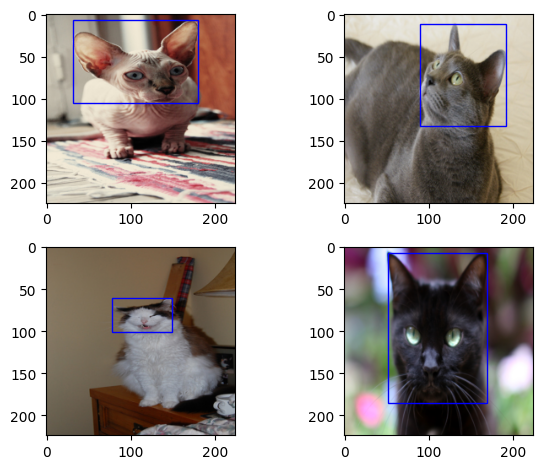

In [84]:
model.eval()

batch = next(iter(val_dataloader))
images = torch.stack([b[0] for b in batch]).to(device)
bboxes = [b[2] for b in batch]
with torch.no_grad():
    scores_preds, bboxes_preds = model(images)
for i in range(4):
    plt.subplot(2, 2, i+1)
    image = images[i].permute(1, 2, 0).cpu()*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    plt.imshow(image)
    image_scores = scores_preds[i, 0].flatten()
    image_bboxes = bboxes_preds[i].flatten(1).T
    image_bboxes = image_bboxes[image_scores >= 0.5]
    image_scores = image_scores[image_scores >= 0.5]
    for x1, y1, x2, y2 in image_bboxes.cpu():
        plt.gca().add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='r', linestyle='--'))
    for x1, y1, x2, y2 in bboxes[i].cpu():
        plt.gca().add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='b'))
plt.tight_layout()
plt.show()

(after NMS. use a low minimum IoU=0.10)

You may use the [NMS function](https://pytorch.org/vision/master/generated/torchvision.ops.nms.html) from pytorch.

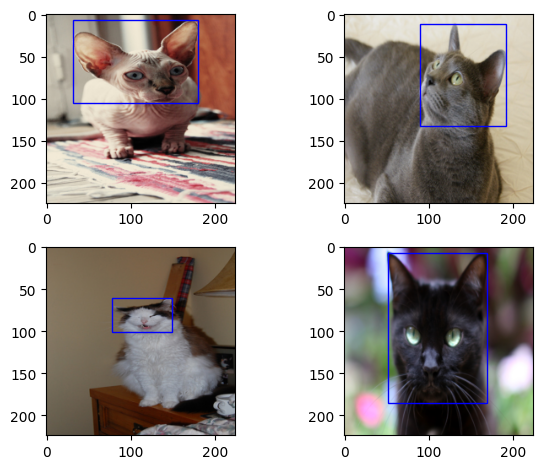

In [85]:
model.eval()

batch = next(iter(val_dataloader))
images = torch.stack([b[0] for b in batch]).to(device)
bboxes = [b[2] for b in batch]
with torch.no_grad():
    scores_preds, bboxes_preds = model(images)
for i in range(4):
    plt.subplot(2, 2, i+1)
    image = images[i].permute(1, 2, 0).cpu()*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    plt.imshow(image)
    image_scores = scores_preds[i, 0].flatten()
    image_bboxes = bboxes_preds[i].flatten(1).T
    image_bboxes = image_bboxes[image_scores >= 0.5]
    image_scores = image_scores[image_scores >= 0.5]
    # HERE: add NMS line
    ix = ...
    image_bboxes = image_bboxes[ix]
    for x1, y1, x2, y2 in image_bboxes.cpu():
        plt.gca().add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='r', linestyle='--'))
    for x1, y1, x2, y2 in bboxes[i].cpu():
        plt.gca().add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='b'))
plt.tight_layout()
plt.show()

Theoretical question: is there a limit to how many objects a YOLO can detect?

### Object Detection with Ultralytics YOLOv8

You do not need GPU to run this notebook, since we will use an existing model and not train it.

Before you start, load the ```images.zip``` file into Google Colab (by uploading it to the ```files``` section).

In [97]:
!unzip "/content/images.zip" -d "/content/data"

Archive:  images.tar.gz
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of images.tar.gz or
        images.tar.gz.zip, and cannot find images.tar.gz.ZIP, period.


There are many different versions of YOLO available. We will be using YOLOv8.

YOLOv8 was originally proposed and implemented by Ultralytics. To work with the model, we will use the ```ultralytics``` package.

Note that this package contains implementations of various models. [Click here](https://docs.ultralytics.com/models/) to find out which models are available on ```ultralytics```.

In [89]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.1/107.7 GB disk)


In [90]:
import os
import matplotlib.pyplot as plt

### Load model

YOLOv8 comes in different versions. [Click here](https://docs.ultralytics.com/models/yolov8/) to see available versions and their computational efficiency and predictive performance on the datasets they were trained.

In [91]:
from ultralytics import YOLO

# Load a pretrained model
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 97.1MB/s]


Create folder to save the results

In [92]:
folder_name = "results"
os.mkdir(folder_name)

### Inference

To apply the model to predict bounding boxes on images, we can use the ```predict()``` function. This function can receive many different inputs, including an image loaded with cv2, the path to an image and even a path to the folder that loads the images. [Click here](https://docs.ultralytics.com/modes/predict/) for more information about the inference process using YOLOv8.

We will provide the path to the folder as input to obtain predictions for all the images.

In [101]:
input_image_folder = '/content/myImages/'

# Predict bounding boxes for the images
results = model.predict(input_image_folder)

for result in results:
    # Get bounding boxes object for bounding box outputs
    boxes = result.boxes
    # Save image with bounding boxes and predictions to folder
    image_name = result.path.split(os.sep)[-1]
    result.save(filename=os.path.join(folder_name, image_name))

# Uncomment to visualize the attributes that a bounding box contains
# print(boxes[0])


image 1/3 /content/myImages/Abyssinian_1.jpg: 448x640 1 cat, 1 dog, 1 couch, 901.0ms
image 2/3 /content/myImages/Abyssinian_106.jpg: 448x640 1 cat, 1 couch, 1 bed, 679.5ms
image 3/3 /content/myImages/Abyssinian_196.jpg: 480x640 1 bird, 2 cats, 744.6ms
Speed: 4.6ms preprocess, 775.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Visualize results

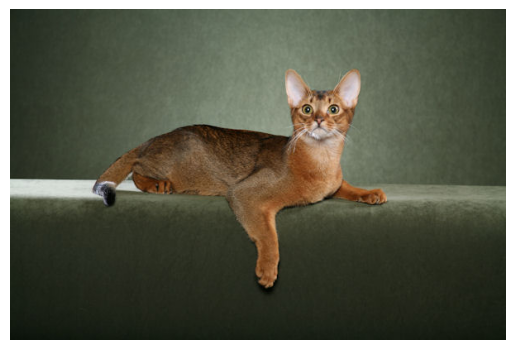

In [104]:
img = plt.imread('/content/myImages/Abyssinian_1.jpg')
plt.axis('off')
plt.imshow(img)

### Altering Parameters: Confidence Threshold and Non Maximum Suppression

**Exercise 1**: Increase/decrease the **confidence threshold** and compare the results.

When you increase/decrease the threshold, how does the number of detected objects change? And why?

In [105]:
folder_name = "results_cnf"
os.mkdir(folder_name)

In [106]:
# Predict bounding boxes for the images
results = model.predict(input_image_folder, conf=0.5)  # return a list of Results objects

for result in results:
    # Get bounding boxes object for bounding box outputs
    boxes = result.boxes
    # Save image with bounding boxes and predictions to folder
    image_name = result.path.split(os.sep)[-1]
    result.save(filename=os.path.join(folder_name, image_name))


image 1/3 /content/myImages/Abyssinian_1.jpg: 448x640 1 cat, 1 dog, 449.0ms
image 2/3 /content/myImages/Abyssinian_106.jpg: 448x640 1 cat, 1 couch, 798.5ms
image 3/3 /content/myImages/Abyssinian_196.jpg: 480x640 1 cat, 467.8ms
Speed: 7.9ms preprocess, 571.8ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 640)


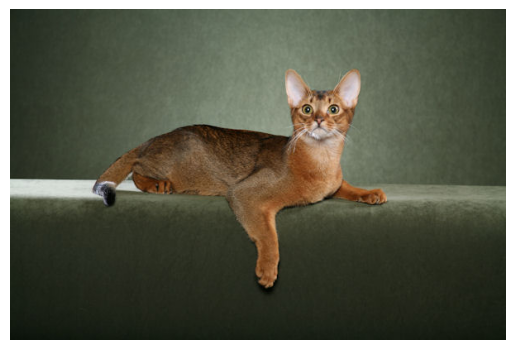

In [108]:
img = plt.imread("/content/myImages/Abyssinian_1.jpg")
plt.axis('off')
plt.imshow(img)

**Exercise 2**: Increase/decrease the Non Maximum Suppression (NMS) threshold and compare the results.

When you increase/decrease the threshold, how does the number of detected objects change? And why?

In [109]:
folder_name = "results_iou"
os.mkdir(folder_name)

In [110]:
# Predict bounding boxes for the images
results = model.predict(input_image_folder, iou=0.4)  # return a list of Results objects

for result in results:
    # Get bounding boxes object for bounding box outputs
    boxes = result.boxes
    # Save image with bounding boxes and predictions to folder
    image_name = result.path.split(os.sep)[-1]
    result.save(filename=os.path.join(folder_name, image_name))


image 1/3 /content/myImages/Abyssinian_1.jpg: 448x640 1 cat, 1 dog, 1 couch, 470.8ms
image 2/3 /content/myImages/Abyssinian_106.jpg: 448x640 1 cat, 1 couch, 1 bed, 462.9ms
image 3/3 /content/myImages/Abyssinian_196.jpg: 480x640 1 bird, 2 cats, 482.5ms
Speed: 4.8ms preprocess, 472.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


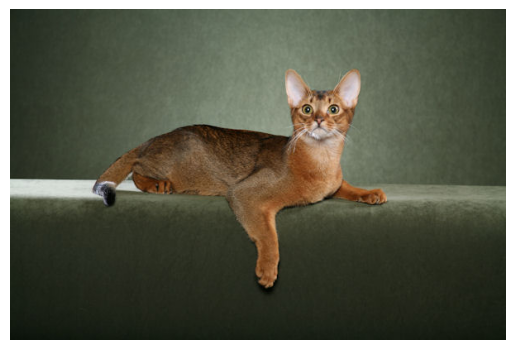

In [111]:
img = plt.imread("/content/myImages/Abyssinian_1.jpg")
plt.axis('off')
plt.imshow(img)

### Extra exercises:

**Semantic segmentation**
1. Replace your U-Net by the more complex U-Net implementation: [https://github.com/milesial/Pytorch-UNet](https://github.com/milesial/Pytorch-UNet).

**Object detection**
1. Add class prediction (cat/dog) to your `MyYOLO` model. Hint: Start by adding that label information to the dataset class.
2. Add multi-scale - i.e., instead of using the last 7x7 layer of resnet-18, use also the previous layers where size was 14x14 and 28x28. The activation layer 7x7 will work better for larger objects (224/7=32) while the prior activation layer 28x28 will work better for smaller objects (224/28=8)